In [4]:
import sys, pathlib
import numpy as np
import pandas as pd

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))


In [5]:
from src.dataset import build_dataset
from src.config import FEATURE_COLS, TARGET_COL

df_feat = build_dataset(include_vix=True)

print("Shape:", df_feat.shape)
print("Période:", df_feat["date"].min().date(), "→", df_feat["date"].max().date())
print("Features utilisées:", [c for c in FEATURE_COLS if c in df_feat.columns])
print("Target balance:", df_feat[TARGET_COL].value_counts(normalize=True).round(3))
df_feat.head()


Shape: (9267, 22)
Période: 1990-01-03 → 2025-10-23
Features utilisées: ['ret_lag1', 'ret_lag2', 'ret_lag3', 'ret_lag5', 'ret_rollmean_5', 'ret_rollstd_5', 'ret_rollstd_10', 'ret_rollstd_20', 'abs_ret_lag1', 'range_pct', 'vix_lag1']
Target balance: y_up
1    0.502
0    0.498
Name: proportion, dtype: float64


,date,open,high,low,close,vix,ret,ret_lag1,ret_lag2,ret_lag3,...,ret_rollstd_5,ret_rollstd_10,ret_rollstd_20,abs_ret_lag1,ret_ewmstd_20,ret_z_20,range_pct,vix_lag1,close_tomorrow,y_up
0,1990-01-03,1.1333,1.1333,1.1333,1.1333,18.19,-0.007010,-0.011262,-0.001211,0.001560,...,0.006691,0.007207,0.006850,0.011262,0.006815,-1.023220,0.0,17.24,1.1585,1
1,1990-01-04,1.1585,1.1585,1.1585,1.1585,19.22,0.022236,-0.007010,-0.011262,-0.001211,...,0.012948,0.009500,0.008245,0.007010,0.009183,2.696909,0.0,18.19,1.1605,1
2,1990-01-05,1.1605,1.1605,1.1605,1.1605,20.11,0.001726,0.022236,-0.007010,-0.011262,...,0.012950,0.009364,0.008211,0.022236,0.008740,0.210252,0.0,19.22,1.1686,1
3,1990-01-08,1.1686,1.1686,1.1686,1.1686,20.26,0.006980,0.001726,0.022236,-0.007010,...,0.013134,0.009266,0.008135,0.001726,0.008417,0.857958,0.0,20.11,1.1594,0
4,1990-01-09,1.1594,1.1594,1.1594,1.1594,22.20,-0.007873,0.006980,0.001726,0.022236,...,0.012305,0.009541,0.008478,0.006980,0.008652,-0.928557,0.0,20.26,1.1609,1


In [6]:
from src.modeling import train_test_split_time

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)
print("Train:", len(X_train), "| Test:", len(X_test))


Train: 7413 | Test: 1854


In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
pred = dummy.predict(X_test)
print("Dummy accuracy:", round(accuracy_score(y_test, pred), 3))

dummy_s = DummyClassifier(strategy="stratified", random_state=0)
dummy_s.fit(X_train, y_train)
proba = dummy_s.predict_proba(X_test)[:, 1]
print("Dummy ROC-AUC:", round(roc_auc_score(y_test, proba), 3))


Dummy accuracy: 0.502
Dummy ROC-AUC: 0.507


In [8]:
from src.modeling import (
    build_logreg_pipeline,
    build_decision_tree,
    build_random_forest,
    build_gradient_boosting,
)
from src.evaluation import evaluate_classifier

models = {
    "LogReg": build_logreg_pipeline(),
    "DecisionTree": build_decision_tree(),
    "RandomForest": build_random_forest(),
    "GradientBoosting": build_gradient_boosting(),
}

results = []
for name, m in models.items():
    m.fit(X_train, y_train)
    acc, auc = evaluate_classifier(m, X_train, y_train, X_test, y_test, name=name)
    results.append((name, acc, auc))

pd.DataFrame(results, columns=["model", "accuracy", "roc_auc"]).sort_values("roc_auc", ascending=False)


=== LogReg ===
Accuracy: 0.504
ROC-AUC : 0.496
Confusion matrix:
 [[334 589]
 [331 600]]

Classification report:
               precision    recall  f1-score   support

           0      0.502     0.362     0.421       923
           1      0.505     0.644     0.566       931

    accuracy                          0.504      1854
   macro avg      0.503     0.503     0.493      1854
weighted avg      0.503     0.504     0.494      1854

=== DecisionTree ===
Accuracy: 0.517
ROC-AUC : 0.522
Confusion matrix:
 [[291 632]
 [263 668]]

Classification report:
               precision    recall  f1-score   support

           0      0.525     0.315     0.394       923
           1      0.514     0.718     0.599       931

    accuracy                          0.517      1854
   macro avg      0.520     0.516     0.496      1854
weighted avg      0.520     0.517     0.497      1854

=== RandomForest ===
Accuracy: 0.497
ROC-AUC : 0.499
Confusion matrix:
 [[313 610]
 [322 609]]

Classification r

,model,accuracy,roc_auc
1,DecisionTree,0.517260,0.522168
3,GradientBoosting,0.511327,0.519898
2,RandomForest,0.497303,0.499100
0,LogReg,0.503776,0.495801


In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score

def walk_forward_scores(model, X, y, n_splits=5):
    """
    Walk-forward simple : on entraîne sur le passé, on teste sur le futur (TimeSeriesSplit).
    Retourne la moyenne des ROC-AUC et accuracies.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 pour horizon J+1
    aucs, accs = [], []

    for train_idx, test_idx in tscv.split(X):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        model.fit(Xtr, ytr)
        proba = model.predict_proba(Xte)[:, 1]
        pred = (proba >= 0.5).astype(int)

        aucs.append(roc_auc_score(yte, proba))
        accs.append(accuracy_score(yte, pred))

    return float(np.mean(accs)), float(np.mean(aucs))


In [10]:
X = df_feat[[c for c in FEATURE_COLS if c in df_feat.columns]].values
y = df_feat[TARGET_COL].values

wf_results = []
for name, m in models.items():
    acc_m, auc_m = walk_forward_scores(m, X, y, n_splits=5)
    wf_results.append((name, acc_m, auc_m))

pd.DataFrame(wf_results, columns=["model", "wf_accuracy", "wf_roc_auc"]).sort_values("wf_roc_auc", ascending=False)


,model,wf_accuracy,wf_roc_auc
3,GradientBoosting,0.497150,0.501075
0,LogReg,0.494171,0.500555
1,DecisionTree,0.492746,0.498573
2,RandomForest,0.492228,0.492165


In [11]:
from src.modeling import grid_search_timeseries
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6, 8],
    "min_samples_leaf": [20, 50],
}

rf_best, rf_params, rf_cvscore = grid_search_timeseries(
    rf_base, param_grid_rf, X_train, y_train, n_splits=5
)

print("Best RF params:", rf_params)
print("CV ROC-AUC:", round(rf_cvscore, 3))


Best RF params: {'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 200}
CV ROC-AUC: 0.496


In [12]:
acc_rf_best, auc_rf_best = evaluate_classifier(
    rf_best, X_train, y_train, X_test, y_test, name="RandomForest tuned (TS CV)"
)


=== RandomForest tuned (TS CV) ===
Accuracy: 0.497
ROC-AUC : 0.498
Confusion matrix:
 [[309 614]
 [318 613]]

Classification report:
               precision    recall  f1-score   support

           0      0.493     0.335     0.399       923
           1      0.500     0.658     0.568       931

    accuracy                          0.497      1854
   macro avg      0.496     0.497     0.483      1854
weighted avg      0.496     0.497     0.484      1854



In [13]:
from sklearn.metrics import balanced_accuracy_score, brier_score_loss

def extra_metrics(model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return {
        "balanced_acc": balanced_accuracy_score(y_test, pred),
        "brier": brier_score_loss(y_test, proba),
    }

extras = []
for name, m in models.items():
    m.fit(X_train, y_train)
    extras.append((name, *extra_metrics(m, X_test, y_test).values()))

pd.DataFrame(extras, columns=["model", "balanced_acc", "brier"]).sort_values("brier")


,model,balanced_acc,brier
3,GradientBoosting,0.510987,0.250213
0,LogReg,0.503166,0.250255
2,RandomForest,0.496623,0.250283
1,DecisionTree,0.516392,0.251269


In [14]:
from sklearn.metrics import roc_auc_score

# On reconstruit un df_test aligné avec le split (80/20)
cut = int(len(df_feat) * 0.8)
df_test = df_feat.iloc[cut:].copy().reset_index(drop=True)

# On prend un modèle "best" pour illustrer (RF tuned sinon RF normal)
best_model = rf_best
best_model.fit(X_train, y_train)

proba_test = best_model.predict_proba(X_test)[:, 1]
df_test["proba_up"] = proba_test

# AUC par année (si assez de points)
df_test["year"] = df_test["date"].dt.year
by_year = []
for year, sub in df_test.groupby("year"):
    if sub[TARGET_COL].nunique() < 2:
        continue
    auc_y = roc_auc_score(sub[TARGET_COL], sub["proba_up"])
    by_year.append((year, auc_y, len(sub)))

pd.DataFrame(by_year, columns=["year", "roc_auc", "n"]).sort_values("year")


,year,roc_auc,n
0,2018,0.408964,93
1,2019,0.483165,258
2,2020,0.489051,259
3,2021,0.569882,259
4,2022,0.530168,258
5,2023,0.514129,258
6,2024,0.519892,259
7,2025,0.451994,210


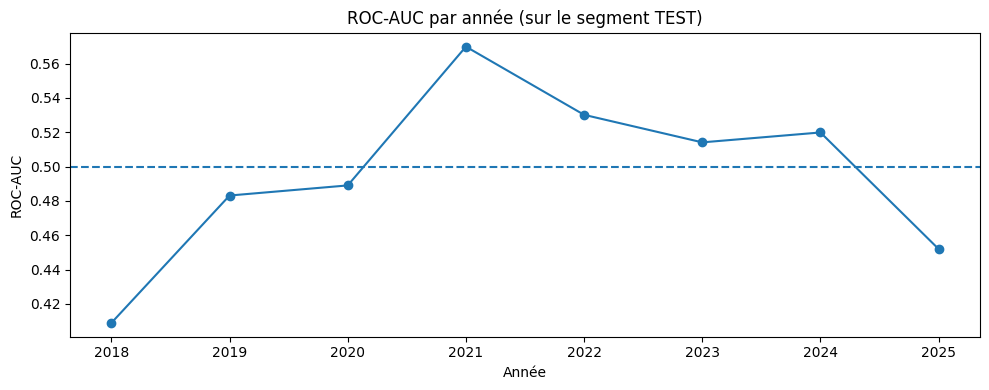

In [15]:
import matplotlib.pyplot as plt

df_auc_year = pd.DataFrame(by_year, columns=["year", "roc_auc", "n"]).sort_values("year")

plt.figure(figsize=(10, 4))
plt.plot(df_auc_year["year"], df_auc_year["roc_auc"], marker="o")
plt.axhline(0.5, linestyle="--")
plt.title("ROC-AUC par année (sur le segment TEST)")
plt.xlabel("Année")
plt.ylabel("ROC-AUC")
plt.tight_layout()
plt.show()
